# Introduzione

Questo progetto mira a condurre un’analisi approfondita del dataset Breast Cancer Wisconsin (Diagnostic), derivato dallo studio di Street, Wolberg e Mangasarian (1993).
Il dataset contiene misurazioni morfologiche e di texture dei nuclei cellulari ottenute da immagini digitali di aspirazioni con ago sottile di tessuto mammario.
L’obiettivo principale è applicare tecniche di data mining e machine learning per classificare accuratamente i campioni come benigni o maligni, sulla base delle caratteristiche estratte dalle immagini.

Le feature rappresentano parametri geometrici e strutturali dei nuclei, tra cui:
	•	dimensione (raggio, area, perimetro),
	•	forma (compattezza, concavità, simmetria, dimensione frattale),
	•	texture (varianza di intensità dei pixel).

Ogni immagine è descritta da 30 variabili numeriche, derivate da 10 misure di base (media, deviazione standard ed estremo superiore per ciascuna).
L’analisi esplorativa si concentrerà sull’identificazione delle relazioni tra queste feature e sulla loro capacità di discriminare tra tessuti benigni e maligni, con l’obiettivo finale di sviluppare un modello predittivo robusto e interpretabile.



In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [229]:
## --- ANALISI ESPLORATIVA ---

# 1. Carica il dataset (ID 1510)
try:
    data_bunch = fetch_openml(data_id=1510, as_frame=True, parser='auto')
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

# 2. DataFrame
df = data_bunch.frame

# 3. Colonna target
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")

# 4. Controllo nomi colonne
if df.columns.str.startswith('V').any():
    feature_column_names = [
        'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
        'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
        'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
    ]
    df.columns = feature_column_names + [class_column_name]
else:
    feature_column_names = data_bunch.feature_names
    print("Nomi delle colonne già corretti.")

# 5. Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()

# 6. Analisi sbilanciamento classi
print("\n--- Distribuzione delle Classi (Valori Originali) ---")
print(df[class_column_name].value_counts())

Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fr

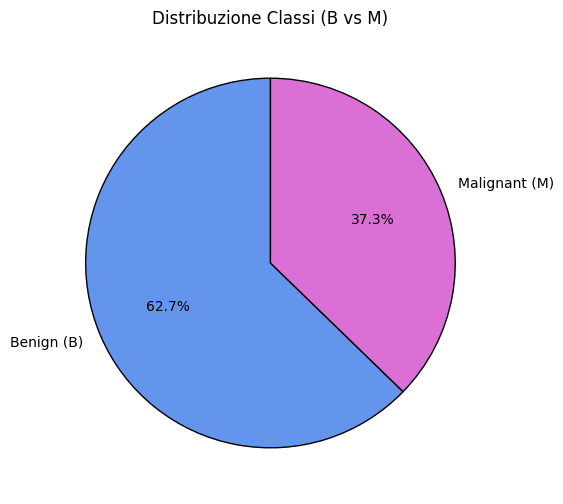

In [230]:
## VISUALIZZAZIONI (Blocco 2.1: Grafico a Torta) ---

# 1. Mappatura delle classi
class_map = {'1': 'Benign (B)', '2': 'Malignant (M)'}
color_map_dict = {'Benign (B)': 'cornflowerblue', 'Malignant (M)': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Diagnosis_Label'] = df[class_column_name].map(class_map)

# 2. Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Diagnosis_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (B vs M)')
plt.ylabel('')
plt.show()

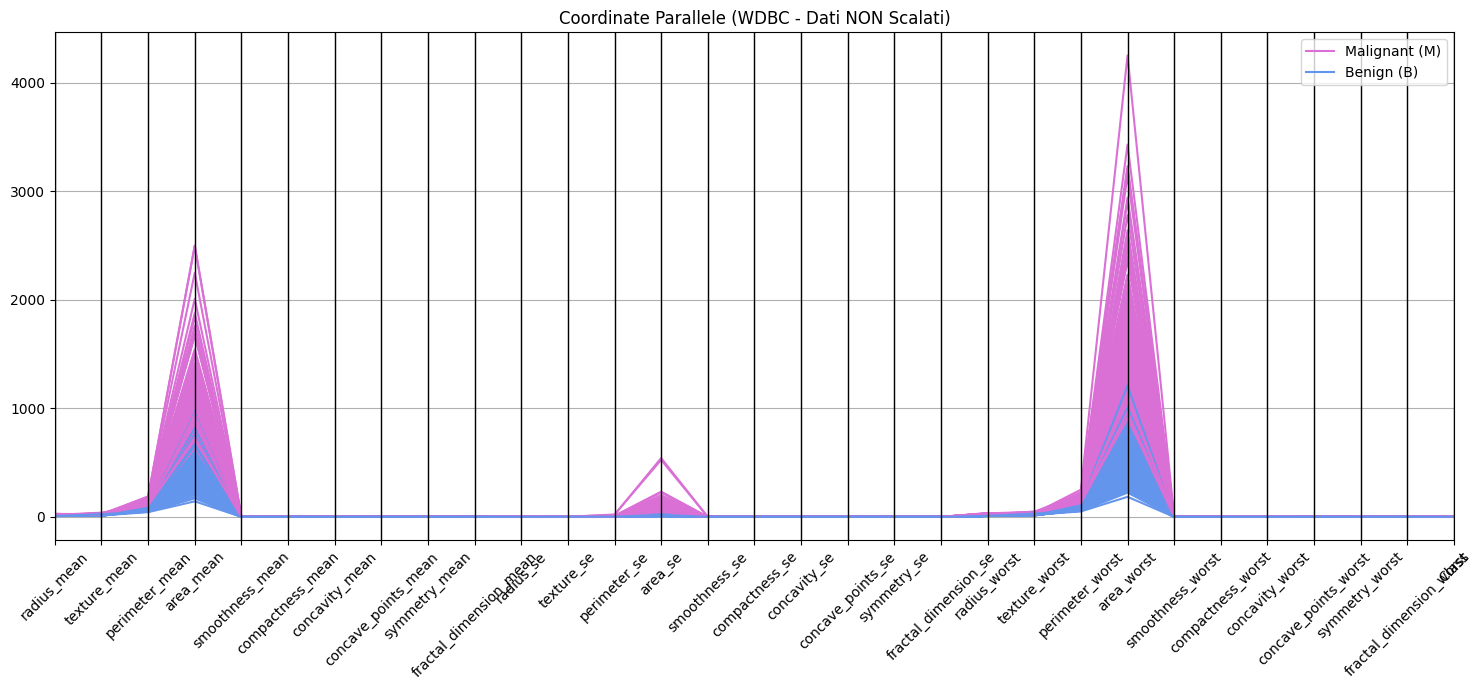

In [231]:
## VISUALIZZAZIONI (Blocco 2.2: Coordinate Parallele - NON Scalati) ---

plt.figure(figsize=(15, 7))

# Ottieni l'ordine delle classi effettive nel DataFrame
class_order = df_plot['Diagnosis_Label'].unique()

# Applica la color map in base all'ordine
colors = [color_map_dict[label] for label in class_order]

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Diagnosis_Label', color=colors)

plt.title('Coordinate Parallele (WDBC - Dati NON Scalati)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Il grafico a coordinate parallele consente di osservare simultaneamente l’andamento delle diverse feature del dataset WDBC confrontando i campioni benigni e maligni. Ogni linea rappresenta un singolo campione, mentre ogni asse verticale corrisponde a una variabile diagnostica. La presenza di due gruppi di linee (viola per i tumori maligni e blu per quelli benigni) permette di identificare visivamente quali feature differenziano maggiormente le due classi.

Dalla visualizzazione emerge che molte delle variabili legate alle dimensioni fisiche del tumore (come radius, perimeter, area e le loro varianti worst) assumono valori significativamente più elevati nei campioni maligni. Questo si traduce in un cluster di linee viola posizionate più in alto lungo questi assi, mentre i campioni benigni mostrano valori generalmente più contenuti e distribuzioni più compatte. Analogamente, le feature che descrivono irregolarità del profilo, come concavity e concave points, presentano differenze marcate tra le due classi, con i maligni che tendono a valori più alti.

Alcune caratteristiche, come smoothness, symmetry e fractal_dimension, mostrano invece una forte sovrapposizione dei due gruppi. Questo suggerisce che, se considerate singolarmente, possiedono un potere discriminante più limitato rispetto alle variabili geometriche principali.

Nel complesso, il grafico mette in evidenza che i tumori maligni si distinguono per dimensioni maggiori e maggiore irregolarità dei contorni. Questa separazione visiva conferma quali feature risultano più informative per i modelli di classificazione e contribuisce a comprendere meglio la struttura interna del dataset prima della fase di modellazione.


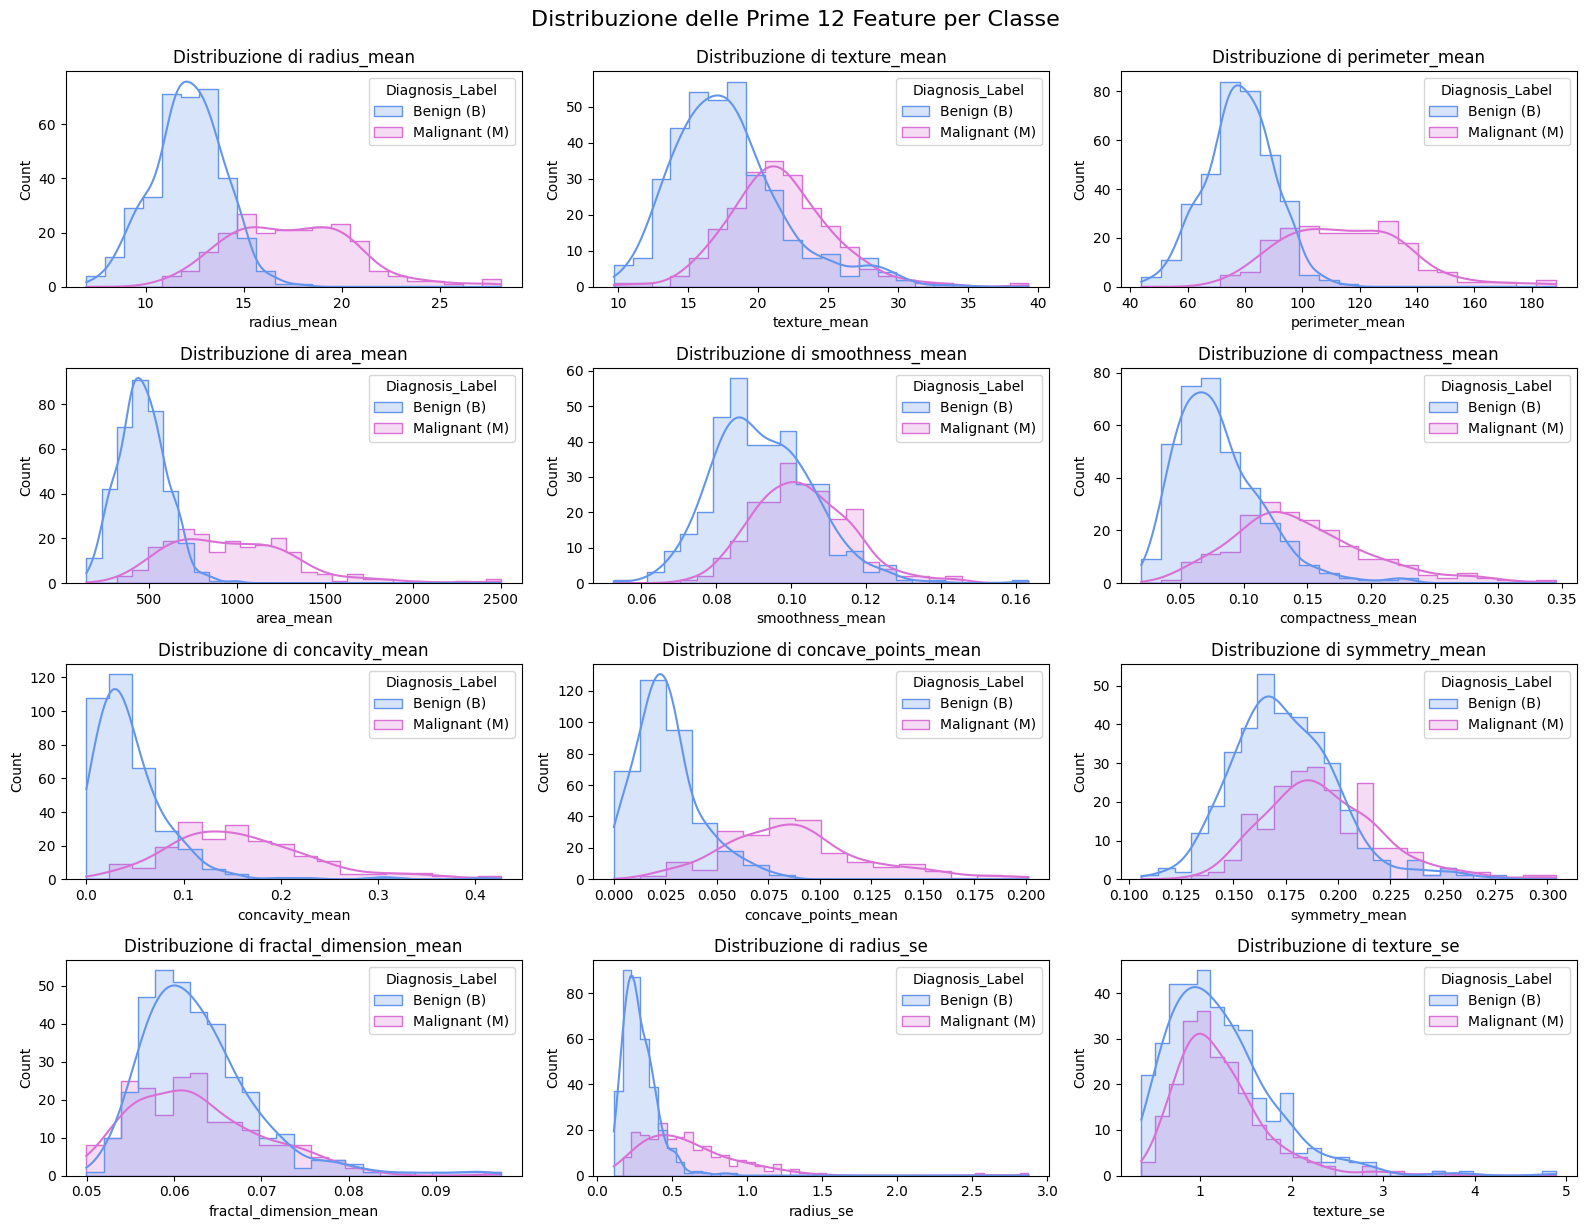

In [232]:
# Prime 12 feature 
features_to_plot = feature_column_names[0:12]

# Costruisci la palette 
palette = {label: color for label, color in color_map_dict.items()}

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Diagnosis_Label',
        kde=True,
        palette=palette,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

Le distribuzioni delle prime dodici feature evidenziano con chiarezza le differenze strutturali tra i campioni benigni e maligni del dataset WDBC. Nelle variabili che descrivono dimensioni e grandezza del tumore — come radius_mean, perimeter_mean, area_mean e radius_se — i tumori maligni tendono a valori più elevati e più dispersi. Le curve corrispondenti presentano infatti code più lunghe e una maggiore variabilità interna, mentre i benigni mostrano distribuzioni più raccolte e centrate verso valori inferiori.

Un comportamento simile emerge anche nelle feature legate all’irregolarità del contorno, come concavity_mean e concave_points_mean. Le distribuzioni dei maligni risultano nettamente spostate verso destra, indicando una maggiore presenza di rientranze e irregolarità nelle masse tumorali maligne rispetto a quelle benigne. Anche su queste variabili la separazione tra le due classi risulta visivamente molto marcata.

Al contrario, alcune feature come smoothness_mean, symmetry_mean e fractal_dimension_mean presentano una notevole sovrapposizione tra le due classi. Pur mostrando differenze statistiche, la distanza tra le distribuzioni è più contenuta, suggerendo che queste variabili contribuiscono meno alla separazione diretta tra benigni e maligni se considerate singolarmente.

Nel complesso, il confronto delle distribuzioni conferma che le caratteristiche dimensionali e morfologiche del tumore rappresentano le principali discriminanti tra le due classi. Le feature geometriche e quelle che descrivono la complessità del bordo mostrano le differenze più evidenti, mentre altre variabili di tipo più fine presentano pattern più similari tra i gruppi. Questo insieme di osservazioni fornisce una panoramica preliminare utile a comprendere quali feature risultano maggiormente informative in vista della fase di modellazione.

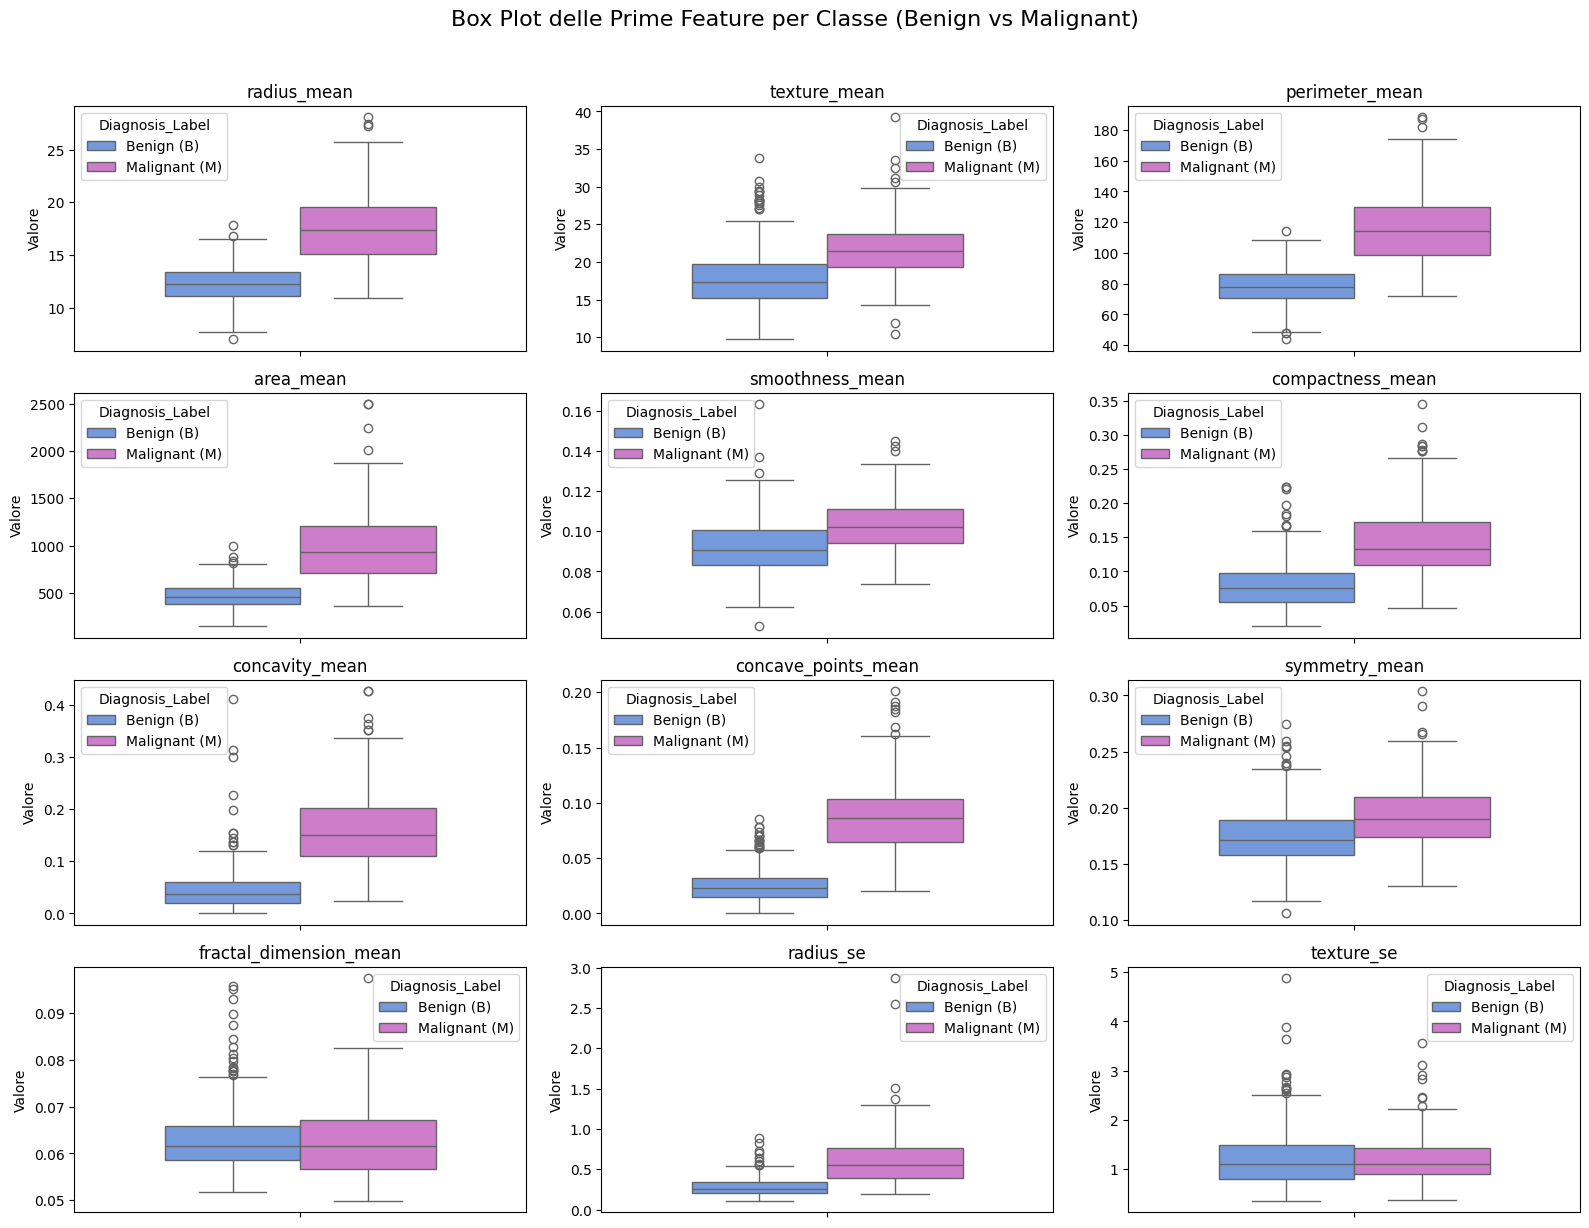

In [233]:
## --- VISUALIZZAZIONI (Blocco 2.5: Box Plot) ---


# Selezioniamo le prime 12 feature
features_to_plot = feature_column_names[:12]  

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(
        df_plot,
        hue='Diagnosis_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Prime Feature per Classe (Benign vs Malignant)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

I box plot delle principali feature permettono di confrontare in modo immediato la distribuzione dei valori tra i campioni benigni e maligni. Osservando le variabili legate alle dimensioni del tumore, come radius_mean, perimeter_mean e area_mean, emerge una differenza netta tra le due classi: i tumori maligni mostrano mediane più elevate e una maggiore ampiezza dell’intervallo interquartile, indicando sia valori tipicamente più alti sia una variabilità superiore rispetto ai tumori benigni.

Anche le feature che descrivono l’irregolarità strutturale, come concavity_mean e concave_points_mean, presentano una separazione evidente. Le mediane dei maligni risultano sistematicamente più alte e sono accompagnate da un numero maggiore di outlier, segnale della maggiore complessità morfologica associata ai tumori maligni.

Al contrario, per variabili come smoothness_mean, symmetry_mean e fractal_dimension_mean la distanza tra i box delle due classi è ridotta. Le mediane risultano più vicine e gli intervalli interquartili mostrano un grado significativo di sovrapposizione, suggerendo un potere discriminante più limitato per queste feature se considerate isolatamente.

Nel complesso, i box plot mettono in luce quali caratteristiche presentano differenze strutturate tra benigni e maligni e confermano che le feature dimensionali e quelle legate alla forma del tumore rappresentano le principali discriminanti nel dataset. Questa visualizzazione rafforza le osservazioni ottenute tramite le distribuzioni e fornisce un ulteriore supporto nella selezione delle feature più informative per la modellazione.

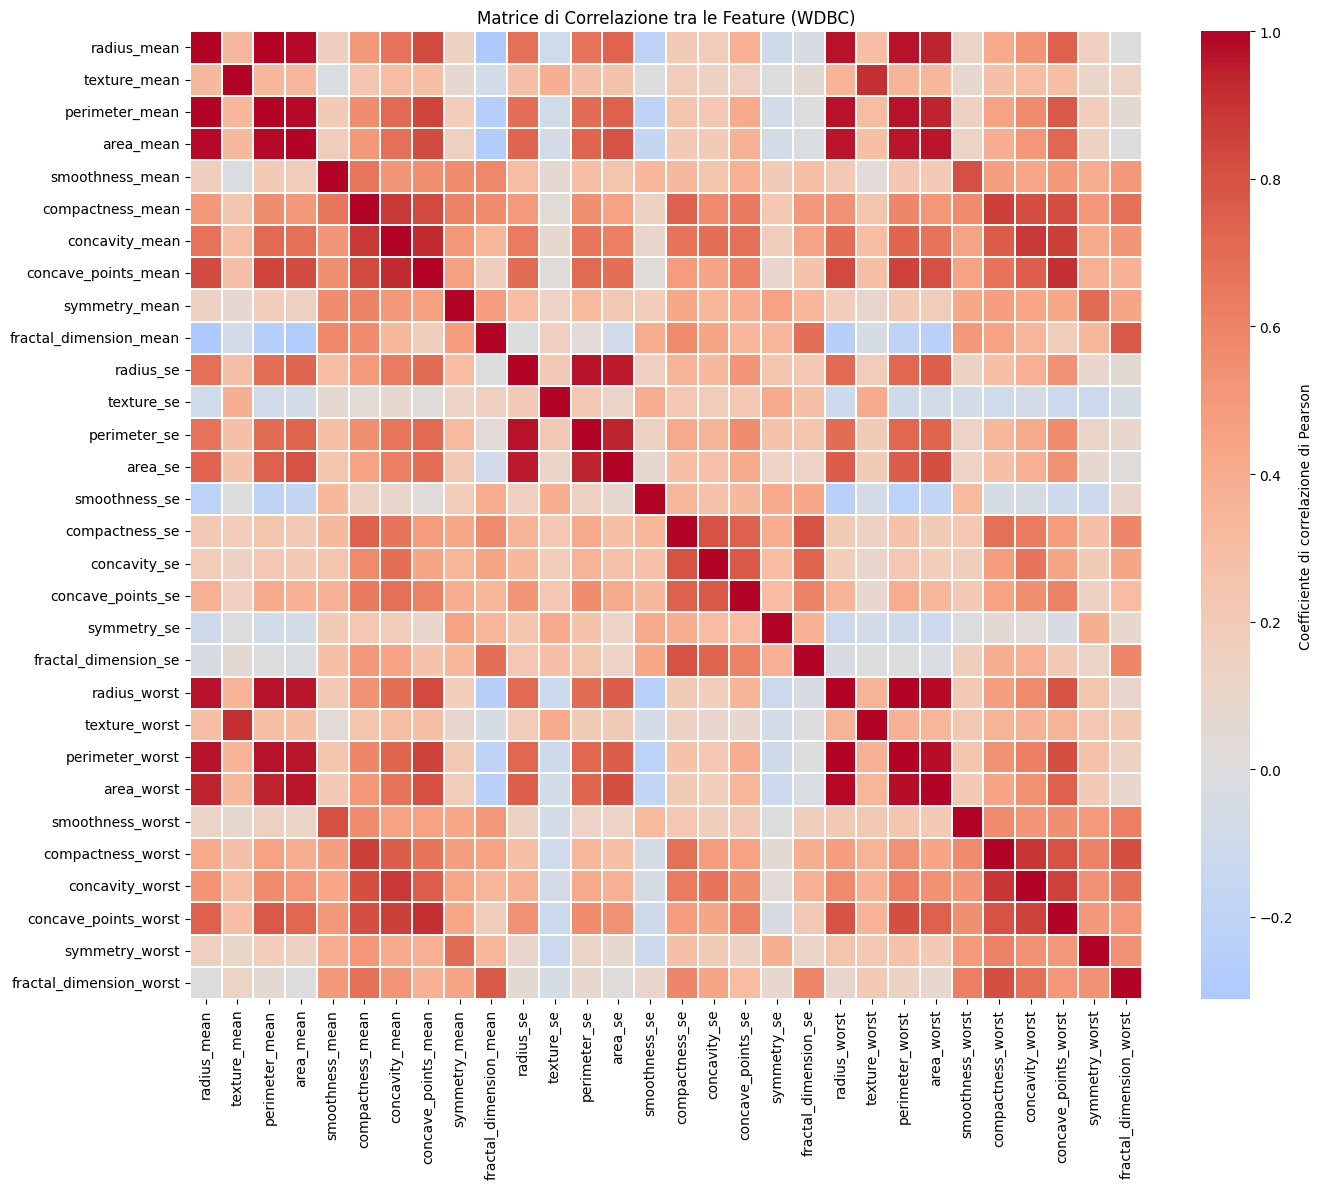

In [234]:
## --- VISUALIZZAZIONI (Blocco 2.4: Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',        
    center=0,             
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature (WDBC)')
plt.tight_layout()
plt.show()

La matrice di correlazione mette in evidenza le relazioni lineari tra tutte le feature del dataset WDBC e permette di individuare rapidamente gruppi di variabili che si muovono in modo simile. Il pattern dominante mostra forti correlazioni positive all’interno dei gruppi di feature relative allo stesso tipo di misura: mean, se e worst. Questo riflette il fatto che le diverse versioni della stessa caratteristica (ad esempio radius_mean, radius_se e radius_worst) catturano aspetti simili della morfologia del tumore.

Le feature dimensionali come radius, perimeter e area mostrano correlazioni molto elevate fra loro, formando un blocco ben definito nella parte superiore sinistra e ripetuto nelle sezioni se e worst. Ciò suggerisce che queste variabili derivano da grandezze geometricamente connesse e quindi tendono a crescere e diminuire insieme. Allo stesso modo, le feature legate alla complessità del contorno, come concavity, concave_points e compactness, presentano correlazioni molto forti, indicando che descrivono aspetti strettamente correlati della forma del tumore.

Sono presenti anche alcune correlazioni moderate tra gruppi diversi, ma meno strutturate. Le feature come smoothness, symmetry e fractal_dimension mostrano correlazioni più deboli con la maggior parte delle altre variabili, confermando il loro ruolo più marginale rispetto alle caratteristiche geometriche principali.

Nel complesso, la matrice evidenzia la presenza di blocchi di feature altamente ridondanti, soprattutto all’interno dei gruppi mean, se e worst. Questo tipo di informazione è utile sia per l’interpretazione del dataset sia per guidare eventuali strategie di selezione o riduzione della dimensionalità, soprattutto quando si desidera evitare la presenza di variabili fortemente collineari nei modelli di classificazione.

In [235]:
## --- PREPROCESSING ---
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 20% per il test set

# 1. Separa X (features) e y (target) dal DataFrame originale
X = df.drop(class_column_name, axis=1)
y = df[class_column_name]

# 2. Encoding del Target (da '2'/'1' a 1/0)
# '2' (Maligno) -> 1
# '1' (Benigno) -> 0
y_numeric = y.map({'2': 1, '1': 0})
print(f"\nTarget convertito in numerico (0=Benigno, 1=Maligno):\n{y_numeric.value_counts()}")


# 3. Divisione in Train/Test 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_numeric, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_numeric 
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")



Target convertito in numerico (0=Benigno, 1=Maligno):
Class
0    357
1    212
Name: count, dtype: int64

Dati di Addestramento (X_train): (455, 30)
Target di Addestramento (y_train): (455,)
Dati di Test (X_test): (114, 30)
Target di Test (y_test): (114,)


In [236]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [237]:
def evaluate_model(model, X_test, y_test, average='macro', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    - average='macro' funziona perfettamente sia per binario che multiclass.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [238]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC(
        random_state=RANDOM_STATE
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

In [239]:
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 1

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- 3. CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=strat_cv, scoring='f1')
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train_scaled, y_train)
    
    metrics = evaluate_model(model, X_test_scaled, y_test, AVERAGE_TYPE, TARGET_LABEL ,False)
    
    metrics["Model"] = name
    results.append(metrics)
    
    cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
    conf_matrices[name] = cm
    
    gen_error = cv_mean - metrics["F1"]
    print(f"   >> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
  
    if cv_mean < 0.6 and metrics["F1"] < 0.6:
        status = "underfitting"
    elif gen_error > 0.10:
        status = "overfitting"
    else:
        status = "good_generalization"
        
    print(f"   >> Model Status: {status}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
   >> Stratified CV F1: 0.8962 (+/- 0.0447)
   >> Generalization Error (CV F1 - Test F1): -0.0088
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: KNN
   >> Stratified CV F1: 0.9538 (+/- 0.0221)
   >> Generalization Error (CV F1 - Test F1): 0.0158
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: SVM
   >> Stratified CV F1: 0.9610 (+/- 0.0082)
   >> Generalization Error (CV F1 - Test F1): -0.0020
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_netw

   >> Stratified CV F1: 0.9704 (+/- 0.0168)
   >> Generalization Error (CV F1 - Test F1): 0.0074
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: Random Forest
   >> Stratified CV F1: 0.9519 (+/- 0.0207)
   >> Generalization Error (CV F1 - Test F1): -0.0111
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: AdaBoost
   >> Stratified CV F1: 0.9546 (+/- 0.0228)
   >> Generalization Error (CV F1 - Test F1): -0.0214
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: XGBoost
   >> Stratified CV F1: 0.9560 (+/- 0.0203)
   >> Generalization Error (CV F1 - Test F1): -0.0070
   >> Model Status: good_generalization
   ------------------------------------------------

Processo completato.


In [240]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
AdaBoost,0.982,1.000,0.952,0.976
SVM,0.974,1.000,0.929,0.963
MLP,0.974,1.000,0.929,0.963
Random Forest,0.974,1.000,0.929,0.963
XGBoost,0.974,1.000,0.929,0.963
KNN,0.956,0.974,0.905,0.938
Decision Tree,0.930,0.905,0.905,0.905


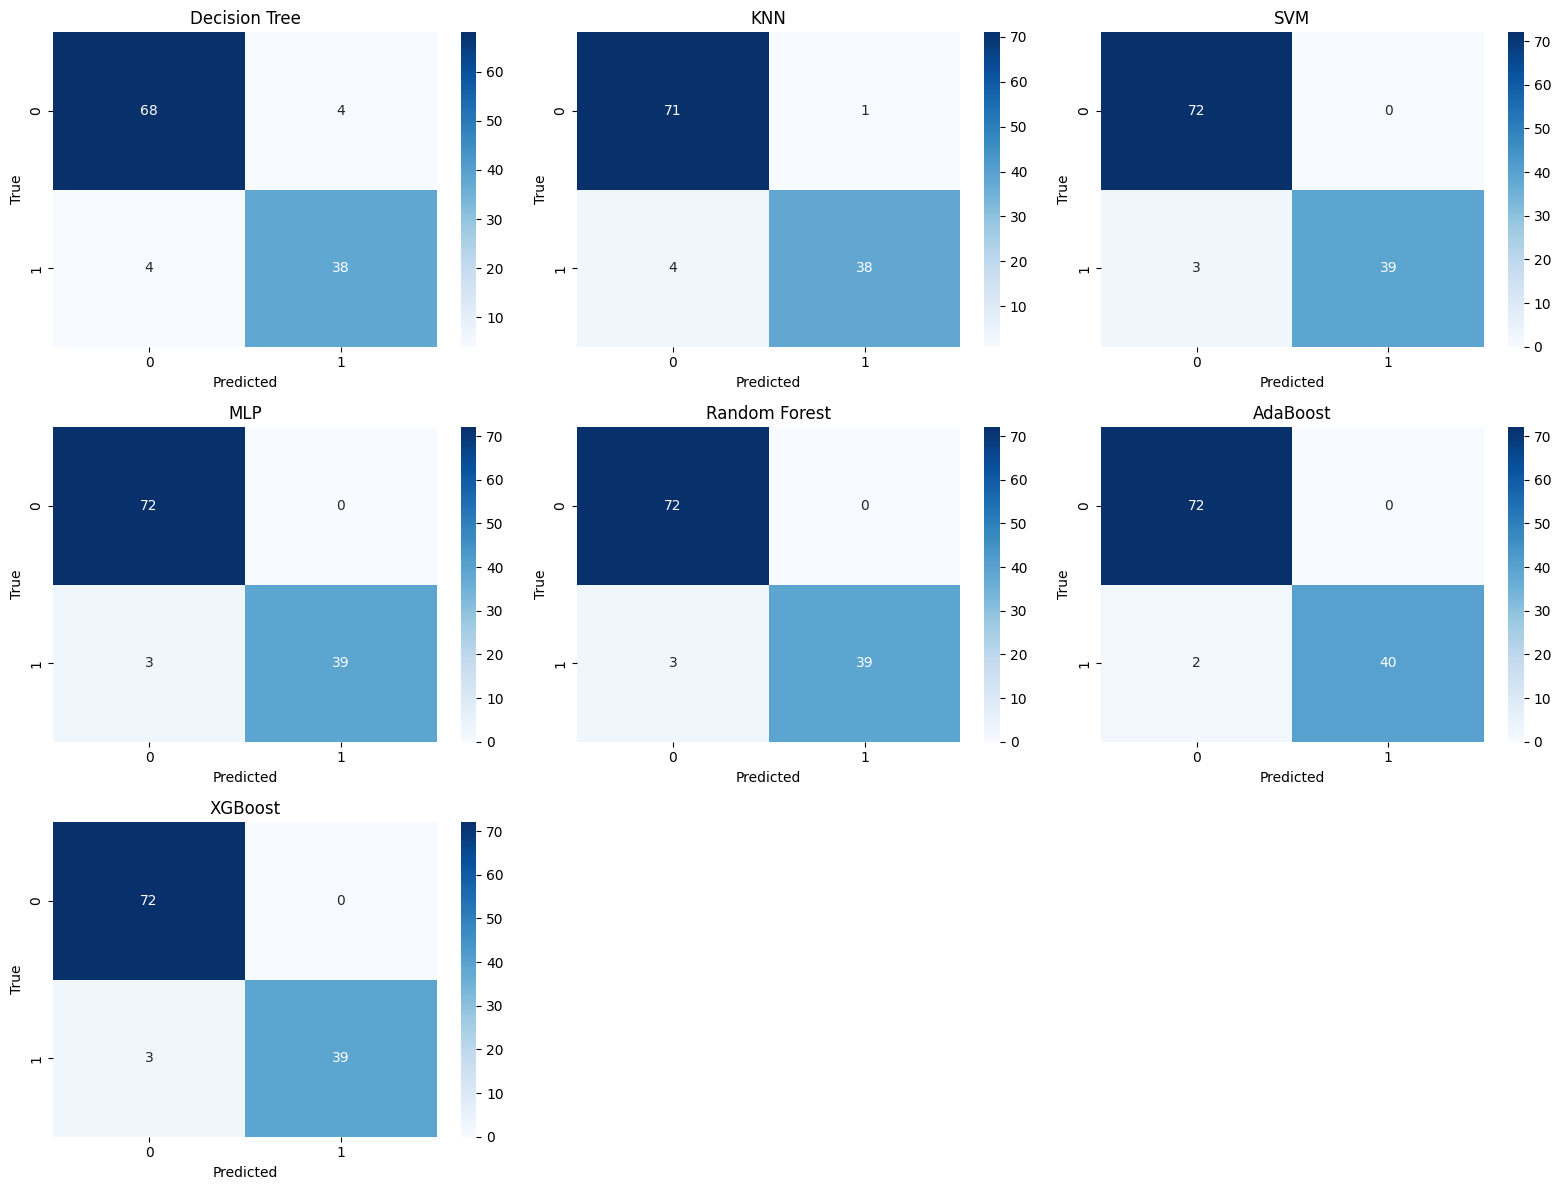

In [241]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

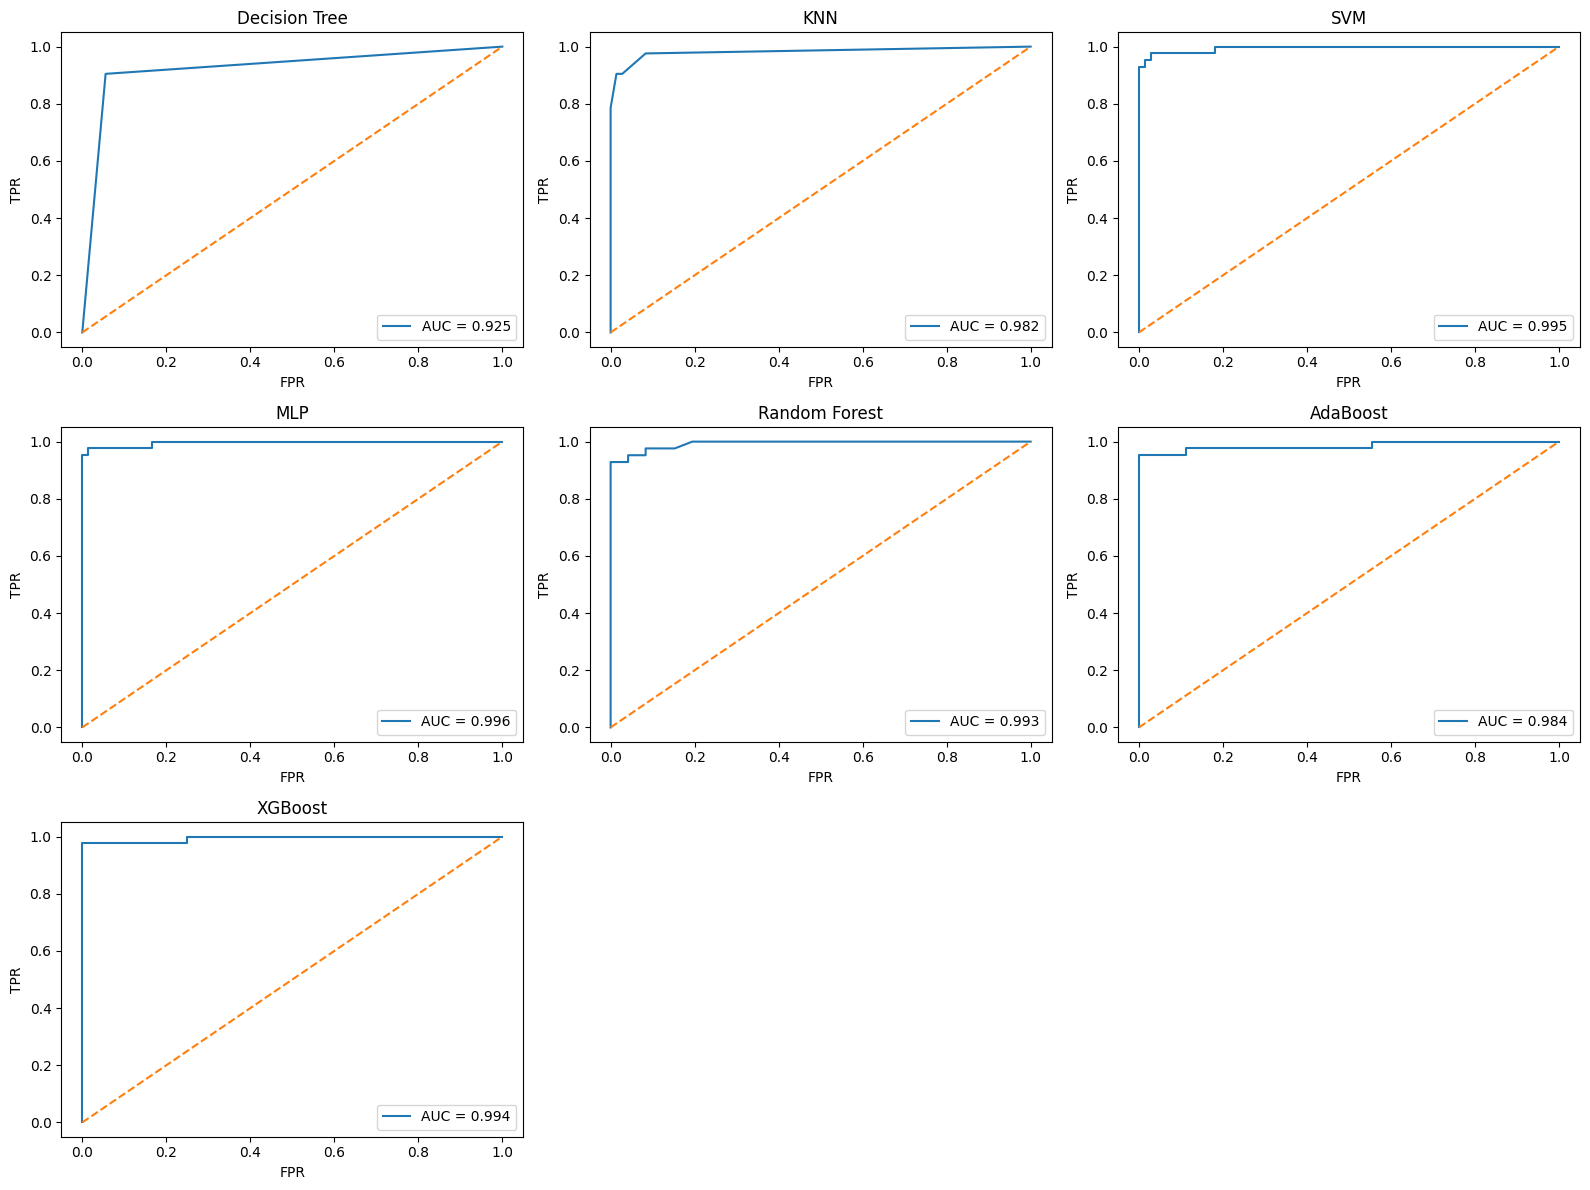

In [242]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

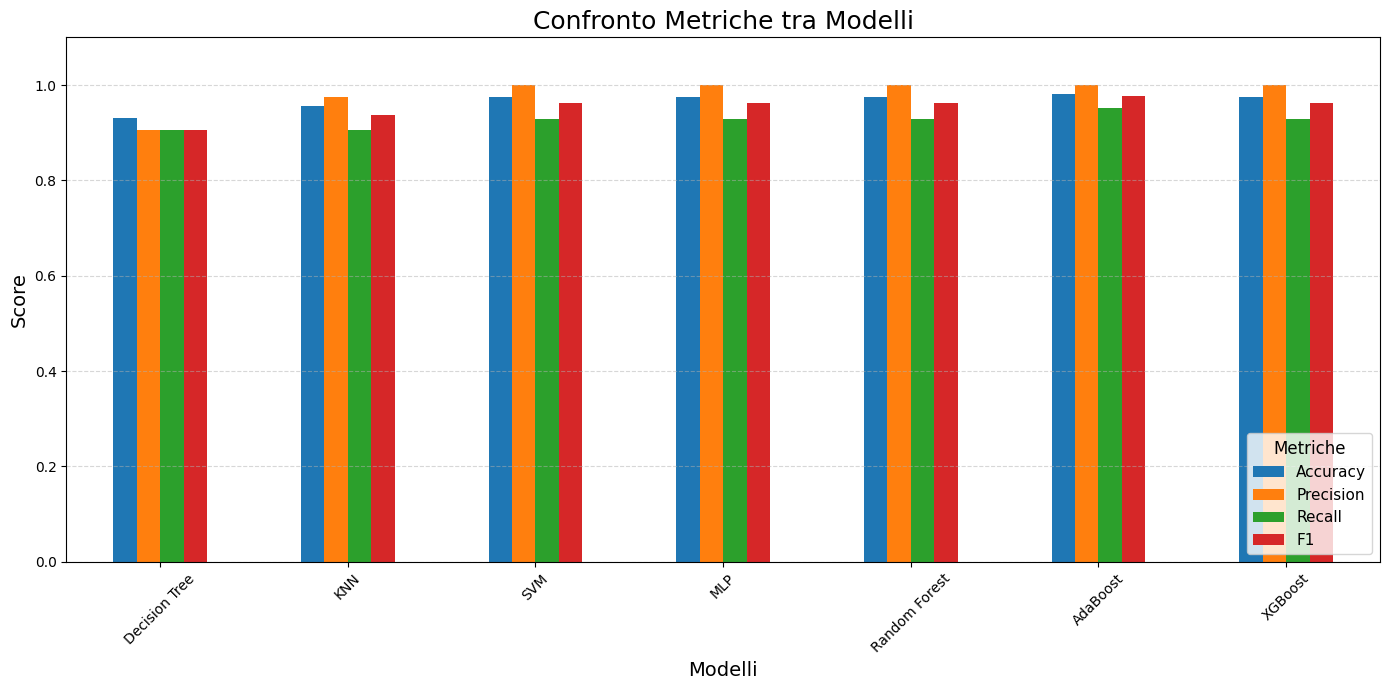

In [243]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [244]:
def train_eval_2d_models(
    models,                      # dict: {"AdaBoost": AdaBoostClassifier(...), "SVM": SVC(...), ...}
    X_train_2d, X_test_2d,
    y_train, y_test,
    feature_names_2d,
    strat_cv,
    task_type='binary',
    pos_label=1,
    do_plot=True
):
    """
    Esegue:
    - CV f1 per ciascun modello
    - fit finale
    - evaluate_model sul test
    - opzionale: plot 2D (una volta sola, non per ogni modello)
    Ritorna un dict con metrics + cv_scores.
    """
    results = {}

    # plot 2D unico (opzionale)
    if do_plot:
        plt.figure(figsize=(8,6))
        plt.scatter(
            X_train_2d[:, 0], X_train_2d[:, 1],
            c=y_train, cmap="coolwarm", alpha=0.7, edgecolor="k"
        )
        plt.xlabel(feature_names_2d[0] + " (Scaled)")
        plt.ylabel(feature_names_2d[1] + " (Scaled)")
        plt.title(f"Distribuzione classi 2D\n({feature_names_2d[0]} & {feature_names_2d[1]})")
        plt.colorbar(label="Classe")
        plt.show()

    for name, est in models.items():
        print(f"\n=== Modello: {name} ===")
        model = clone(est)

        cv_scores = cross_val_score(model, X_train_2d, y_train, cv=strat_cv, scoring='f1')
        cv_mean = cv_scores.mean()
        cv_std  = cv_scores.std()

        print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

        model.fit(X_train_2d, y_train)
        metrics = evaluate_model(model, X_test_2d, y_test, task_type, pos_label, False)

        print("   >> Metriche test:", metrics)

        results[name] = {
            "cv_scores": cv_scores,
            "cv_mean": cv_mean,
            "cv_std": cv_std,
            "metrics": metrics
        }

    return results

In [245]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Varianza spiegata:", pca.explained_variance_ratio_)

Varianza spiegata: [0.44593523 0.18545256]


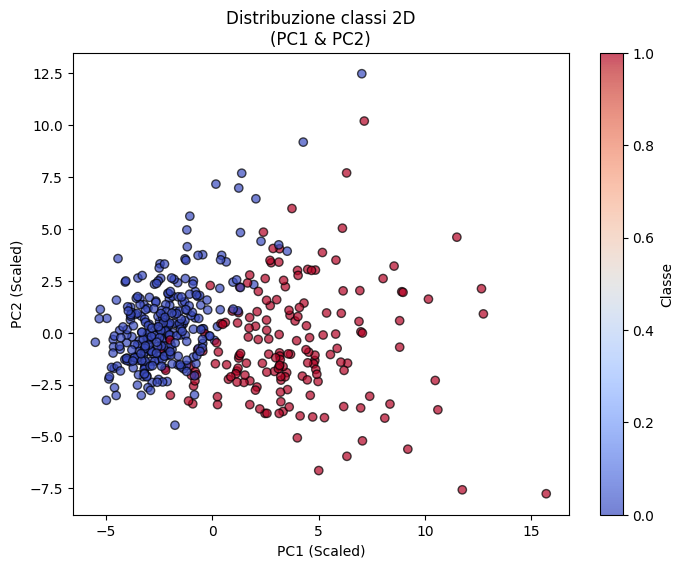


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9130 (+/- 0.0198)
   >> Metriche test: {'Accuracy': 0.956, 'Precision': 0.974, 'Recall': 0.905, 'F1': 0.938}


In [249]:
from sklearn.base import clone

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

results_pca = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=["PC1", "PC2"],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [253]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFE
import pandas as pd

feature_names = np.array(X_train.columns)

ada_selector = AdaBoostClassifier(random_state=42)

rfe_ada = RFE(estimator=ada_selector, n_features_to_select=2, step=1)

X_train_rfe = rfe_ada.fit_transform(X_train_scaled, y_train)
X_test_rfe  = rfe_ada.transform(X_test_scaled)

print("Feature scelte:", feature_names[rfe_ada.support_])
print(f"Feature originali: {X_train_scaled.shape[1]}")
print(f"Feature rimaste: {X_train_rfe.shape[1]}")

Feature scelte: ['perimeter_worst' 'concave_points_worst']
Feature originali: 30
Feature rimaste: 2


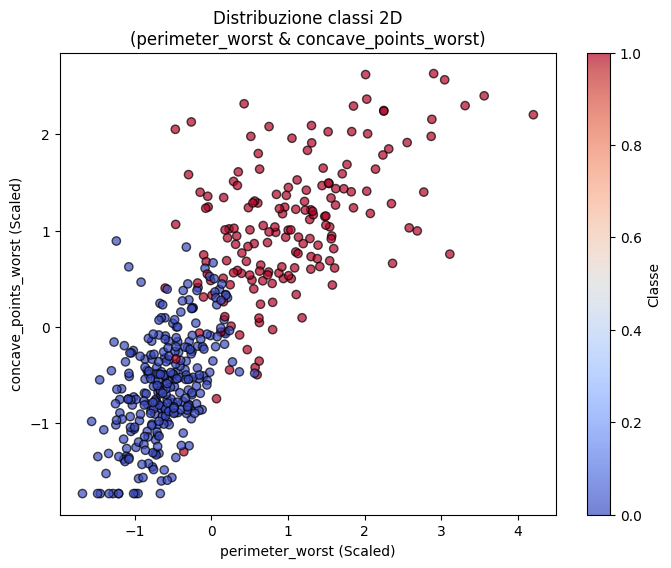


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9033 (+/- 0.0399)
   >> Metriche test: {'Accuracy': 0.939, 'Precision': 0.927, 'Recall': 0.905, 'F1': 0.916}


In [254]:
from sklearn.base import clone

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

results_rfe = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names[rfe_ada.support_],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [255]:
fi_selector = AdaBoostClassifier(random_state=42)
fi_selector.fit(X_train_scaled, y_train)

importances = fi_selector.feature_importances_
feature_names = np.array(X_train.columns)

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("--- Importanza feature (ordinale) ---")
print(feature_importance_df)

# 2) Selezione delle top 2 feature (indici + nomi)
top_k = 2
top_idx = np.argsort(importances)[::-1][:top_k]
top_names = feature_names[top_idx]

print(f"\n--- Top {top_k} feature per importance ---")
print(top_names)

# 3) Creazione dei dataset ridotti (solo le top 2)
X_train_fi = X_train_scaled[:, top_idx]
X_test_fi  = X_test_scaled[:, top_idx]


--- Importanza feature (ordinale) ---
                    Feature  Importance
27     concave_points_worst    0.114789
22          perimeter_worst    0.103677
15           compactness_se    0.086224
1              texture_mean    0.085571
21            texture_worst    0.083780
13                  area_se    0.080973
7       concave_points_mean    0.060447
5          compactness_mean    0.059730
4           smoothness_mean    0.056982
26          concavity_worst    0.049273
28           symmetry_worst    0.044888
10                radius_se    0.043470
24         smoothness_worst    0.030710
19     fractal_dimension_se    0.021436
23               area_worst    0.019289
9    fractal_dimension_mean    0.016866
17        concave_points_se    0.016345
3                 area_mean    0.012811
14            smoothness_se    0.012738
25        compactness_worst    0.000000
0               radius_mean    0.000000
20             radius_worst    0.000000
18              symmetry_se    0.000000
16

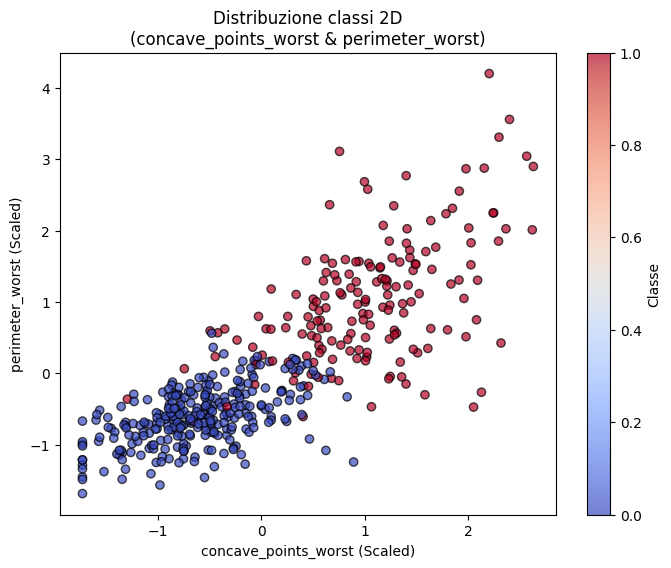


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9033 (+/- 0.0399)
   >> Metriche test: {'Accuracy': 0.939, 'Precision': 0.927, 'Recall': 0.905, 'F1': 0.916}


In [256]:
from sklearn.base import clone

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

results_fi = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names[top_idx],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [257]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# 2) Ordino le feature per importanza MI
feature_names = np.array(feature_names)   
mi_df = pd.DataFrame({
    "Feature": feature_names,
    "MI": mi
}).sort_values(by="MI", ascending=False)

print(mi_df)

# 3) Prendo le top 2
feature_names = mi_df.head(2)["Feature"].values
indices = [list(feature_names).index(f) for f in feature_names]

print("Feature scelte:", feature_names)

# 4) Creo i dataset ridotti
X_train_mi = X_train_scaled[:, indices]
X_test_mi  = X_test_scaled[:, indices]

print(f"Feature originali: {X_train_scaled.shape[1]}")
print(f"Feature rimaste: {X_train_mi.shape[1]}")

                    Feature        MI
20             radius_worst  0.461221
22          perimeter_worst  0.454559
23               area_worst  0.453342
7       concave_points_mean  0.445956
27     concave_points_worst  0.432900
2            perimeter_mean  0.409301
3                 area_mean  0.374696
0               radius_mean  0.373251
6            concavity_mean  0.354085
13                  area_se  0.350009
26          concavity_worst  0.299396
12             perimeter_se  0.265459
10                radius_se  0.231256
25        compactness_worst  0.219574
5          compactness_mean  0.218757
21            texture_worst  0.141689
17        concave_points_se  0.125386
28           symmetry_worst  0.103301
4           smoothness_mean  0.100138
24         smoothness_worst  0.099513
16             concavity_se  0.098647
29  fractal_dimension_worst  0.080793
8             symmetry_mean  0.077825
1              texture_mean  0.072670
15           compactness_se  0.043693
19     fract

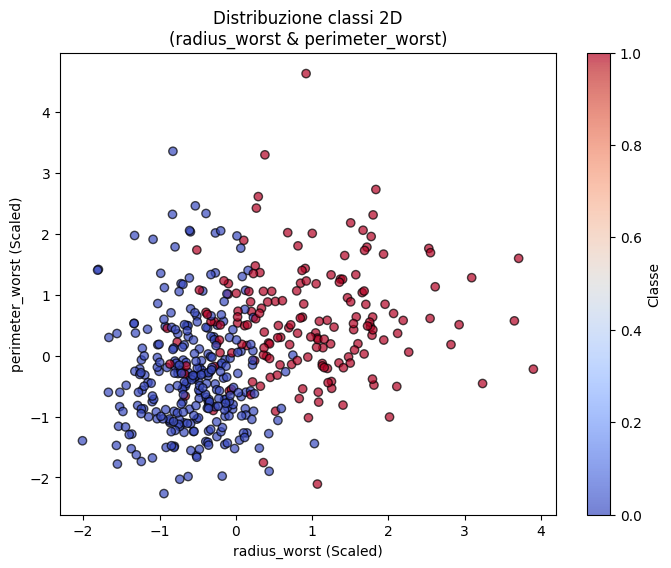


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.8258 (+/- 0.0498)
   >> Metriche test: {'Accuracy': 0.904, 'Precision': 0.897, 'Recall': 0.833, 'F1': 0.864}


In [258]:
from sklearn.base import clone

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

results_mi = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [259]:
df_compare = pd.DataFrame({
    "Original": df_results["F1"]["AdaBoost"],
    "PCA": results_pca["AdaBoost"]["metrics"]["F1"],
    "Feature Importance": results_fi["AdaBoost"]["metrics"]["F1"],
    "RFE": results_rfe["AdaBoost"]["metrics"]["F1"],
    "Mutual Information": results_mi["AdaBoost"]["metrics"]["F1"],
}, index=["F1"])

df_compare

,Original,PCA,Feature Importance,RFE,Mutual Information
F1,0.976,0.938,0.916,0.916,0.864
